In [3]:
from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))
    
reset_keras()    

156


In [4]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.regularizers import L1L2

In [5]:
train_df = pd.read_csv("./input/train.csv")

print("Train shape : ",train_df.shape)


Train shape :  (1306122, 3)


In [6]:
## Config values 
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2019)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=2020)
print("Validation shape : ",val_df.shape)
print("Test shape : ",test_df.shape)
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 50 # max number of words in a question to use

## fill up the missing values
train_X = train_df["question_text"].fillna("_na_").values
val_X = val_df["question_text"].fillna("_na_").values
test_X = test_df["question_text"].fillna("_na_").values

## Tokenize the sentences
oov_tok = "OOV_TOK"
tokenizer = Tokenizer(num_words=max_features) # lower = False, oov_token=oov_tok)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen, truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen, truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen, truncating='post')

## Get the target values
train_y = train_df['target'].values
val_y = val_df['target'].values
test_y = test_df['target'].values

Validation shape :  (130612, 3)
Test shape :  (130613, 3)


In [7]:
EMBEDDING_FILE = './input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/home/user1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [8]:
regularizer = L1L2(l1=0.0, l2=0.001)
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, trainable=True, weights=[embedding_matrix])(inp)
x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           187392    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)    

In [9]:
# Define callback function if detailed log required

class History(Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.train_acc = []
        self.val_acc = []
        self.val_loss = []
        for keys in logs:
           print(keys) 

    def on_batch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.train_acc.append(logs.get('acc'))
    #Store val_acc/loss per batch    
    def on_epoch_end(self, batch, logs={}):    
        self.val_acc.append(logs.get('val_acc'))
        self.val_loss.append(logs.get('val_loss'))
        
# Compute class_weights for imbalanced train set
def compute_class_weight(input_list):

  class_weights = class_weight.compute_class_weight('balanced', 
                                                   np.unique(input_list),  
                                                   input_list)
                                                   
  return(class_weights)                                                   
        
#define callback functions
history = History()
callbacks = [history]        

class_weights = compute_class_weight(train_y)

class_weights[1] *= 10
print(class_weights)

[ 0.53290517 80.97591407]


In [10]:

model.fit(train_X, train_y, 
          batch_size=512, 
          epochs=2, 
          validation_data=(val_X, val_y), 
          class_weight = class_weights,
          callbacks= callbacks)
model.save('./output/model_wiki_emb.h5')

Train on 1044897 samples, validate on 130612 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/2
1044897/1044897 [==============================] - 54s 51us/sample - loss: 0.1146 - acc: 0.9555 - val_loss: 0.1051 - val_acc: 0.9580
Epoch 2/2
1044897/1044897 [==============================] - 51s 49us/sample - loss: 0.0913 - acc: 0.9636 - val_loss: 0.1076 - val_acc: 0.9577


In [11]:
#from tensorflow.keras.models import Model, load_model

#model =load_model('./output/model_glove.h5')
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))

130612/130612 [==============================] - 1s 11us/sample
F1 score at threshold 0.1 is 0.5960733549083064
F1 score at threshold 0.11 is 0.6031494677575436
F1 score at threshold 0.12 is 0.6092685550376479
F1 score at threshold 0.13 is 0.6142270861833106
F1 score at threshold 0.14 is 0.6187983508593135
F1 score at threshold 0.15 is 0.6232177309303092
F1 score at threshold 0.16 is 0.6282597253457103
F1 score at threshold 0.17 is 0.6319417475728154
F1 score at threshold 0.18 is 0.6350925561244585
F1 score at threshold 0.19 is 0.6377230585185923
F1 score at threshold 0.2 is 0.6396364554405454
F1 score at threshold 0.21 is 0.6419955019423431
F1 score at threshold 0.22 is 0.6439362582781457
F1 score at threshold 0.23 is 0.6448778957276577
F1 score at threshold 0.24 is 0.6456692913385826
F1 score at threshold 0.25 is 0.6473605471254542
F1 score at threshold 0.26 is 0.6491909385113268
F1 score at threshold 0.27 is 0.6501197474417592
F1 score at threshold 0.28 is 0.6518559252130878
F1 scor

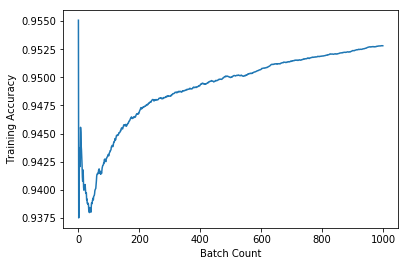

In [12]:
x = range(len(history.train_acc))
%matplotlib inline
fig = plt.figure()
plt.xlabel('Batch Count')
plt.ylabel('Training Accuracy')
plt.plot(x[0:1000], history.train_acc[0:1000])
plt.show()
fig.savefig('wiki_emb_accuracy')

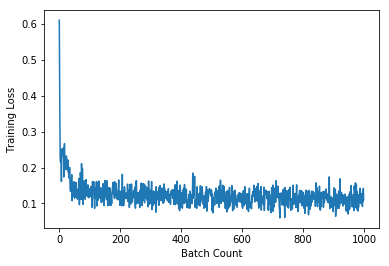

In [13]:
fig = plt.figure()
plt.xlabel('Batch Count')
plt.ylabel('Training Loss')
plt.plot(x[0:1000], history.train_loss[0:1000])
plt.show()
fig.savefig('wiki_emb_loss')

In [ ]:

%matplotlib inline
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
#fig.savefig('self_train_emb_F1_score')

In [14]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
threshold = []
f1_array = []
f1_max = 0
opt_thresh = 0
test_y = test_df['target'].values
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    threshold.append(thresh)
    f1_score = metrics.f1_score(test_y, (pred_test_y>thresh).astype(int))
    if(f1_score > f1_max):
        f1_max = f1_score
        opt_thresh = thresh
    f1_array.append(f1_score)
    print("F1 score at threshold {0} is {1}".format(thresh, f1_score))

pred = [int(a > opt_thresh) for a in pred_test_y]    

130613/130613 [==============================] - 1s 11us/sample
F1 score at threshold 0.1 is 0.6048165923894412
F1 score at threshold 0.11 is 0.6124950746464691
F1 score at threshold 0.12 is 0.6201688932576739
F1 score at threshold 0.13 is 0.6256251705010457
F1 score at threshold 0.14 is 0.631107002542177
F1 score at threshold 0.15 is 0.6353482260183968
F1 score at threshold 0.16 is 0.638401142041399
F1 score at threshold 0.17 is 0.64105283455457
F1 score at threshold 0.18 is 0.6450446930103062
F1 score at threshold 0.19 is 0.6482021860626144
F1 score at threshold 0.2 is 0.650345449083809
F1 score at threshold 0.21 is 0.6513775432543508
F1 score at threshold 0.22 is 0.6531889783980708
F1 score at threshold 0.23 is 0.6549113162535007
F1 score at threshold 0.24 is 0.6584163607760881
F1 score at threshold 0.25 is 0.6596353614585541
F1 score at threshold 0.26 is 0.6603116799657258
F1 score at threshold 0.27 is 0.6611498728973985
F1 score at threshold 0.28 is 0.6623015223440825
F1 score at 

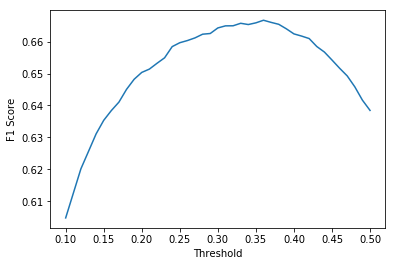

In [15]:
fig = plt.figure()
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.plot(threshold, f1_array)
plt.show()
fig.savefig('wiki_emb_F1_score')

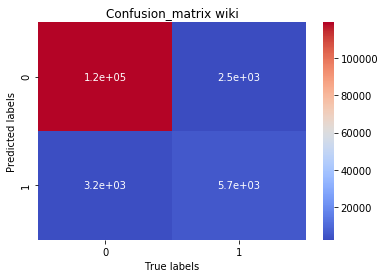

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
import seaborn as sns
def get_confusion_matrix(val_y, pred,title):
    cm=confusion_matrix(pred,val_y)
   
    fig = plt.figure()
    sns.heatmap(cm, cmap='coolwarm', annot=True)
    plt.title(title)
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()
    fig.savefig('wiki_confusion_matrix')
 
get_confusion_matrix(test_y,pred,'Confusion_matrix wiki')    

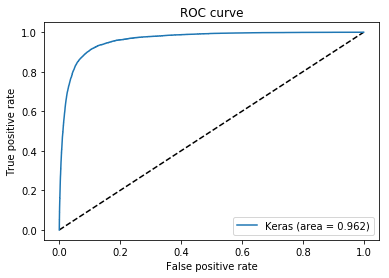

In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_y, pred_test_y)
auc_keras = auc(fpr_keras, tpr_keras)
fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
fig.savefig('Wiki_ROC')